### 0 - Import packages  

In [53]:
! pip install lifelines scikit-survival survshap shap jinja2 seaborn numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeable


In [54]:
#pip install survlimepy

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import survshap
import seaborn as sns 

from sksurv.util import Surv
from sksurv.metrics import brier_score
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
#from survlimepy import SurvLimeExplainer

### 1 - Cleaning data

For this first example, we will use the Metabric Dataset.

We got a sample of it on Kaggle: 

https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric?resource=download


In [56]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data

/tmp/ipykernel_5452/1434437314.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Exploring data, we have 31 variables and a lot of genetic information.
This genetic data, is obviously important and insightful, but we will first get rid of it in order to more easily get a grasp of what survival analyses and models are. 
We also get rid of some variables that we won't use for this example.

We also get rid of the lines with NaN.

In [57]:
data = data.loc[:, :"death_from_cancer"]
Variables_to_drop = [
    "patient_id",
    "cancer_type_detailed",
    "cellularity",
    "pam50_+_claudin-low_subtype",
    "cohort",
    "her2_status_measured_by_snp6",
    "tumor_other_histologic_subtype",
    "integrative_cluster",
    "oncotree_code",
    "3-gene_classifier_subtype",
    "overall_survival"
    ]
columns= list(data.columns)
for i in Variables_to_drop:
    if i in columns:
        data=data.drop(i,axis=1)

data.head(2)

,age_at_diagnosis,type_of_breast_surgery,cancer_type,chemotherapy,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,pr_status,radio_therapy,tumor_size,tumor_stage,death_from_cancer
0,75.65,MASTECTOMY,Breast Cancer,0,Positve,Positive,3.0,Negative,1,Post,Right,10.0,NaN,6.044,140.500000,Negative,1,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Cancer,0,Positve,Positive,3.0,Negative,1,Pre,Right,0.0,2.0,4.020,84.633333,Positive,1,10.0,1.0,Living


In [58]:
data = data.dropna(axis=0)
print( "sample size: ", len(data))
print("")
print("number of different obs")
for i in data.columns:
    print (i, len(data[i].unique()))

sample size:  1273

number of different obs
age_at_diagnosis 1111
type_of_breast_surgery 2
cancer_type 1
chemotherapy 2
er_status_measured_by_ihc 2
er_status 2
neoplasm_histologic_grade 3
her2_status 2
hormone_therapy 2
inferred_menopausal_state 2
primary_tumor_laterality 2
lymph_nodes_examined_positive 28
mutation_count 28
nottingham_prognostic_index 206
overall_survival_months 1169
pr_status 2
radio_therapy 2
tumor_size 66
tumor_stage 4
death_from_cancer 3


Separating variables from censor and survival data and transforming object variables into dummies

In [59]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months"]) 

X = pd.get_dummies(X, columns=[
    "cancer_type",
    "type_of_breast_surgery",
    "er_status_measured_by_ihc",
    "er_status",
    "her2_status",
    "inferred_menopausal_state",
    "primary_tumor_laterality",
    "pr_status"],
     drop_first=True)
X = X.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X.head()

,age_at_diagnosis,chemotherapy,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,radio_therapy,tumor_size,tumor_stage,type_of_breast_surgery_MASTECTOMY,er_status_measured_by_ihc_Positve,er_status_Positive,her2_status_Positive,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,pr_status_Positive
1,43.19,0,3.0,1,0.0,2.0,4.020,1,10.0,1.0,0,1,1,0,1,1,1
2,48.87,1,2.0,1,1.0,2.0,4.030,0,15.0,2.0,1,1,1,0,1,1,1
3,47.68,1,2.0,1,3.0,1.0,4.050,1,25.0,2.0,1,1,1,0,1,1,1
4,76.97,1,3.0,1,8.0,2.0,6.080,1,40.0,2.0,1,1,1,0,0,1,1
5,78.77,0,3.0,1,0.0,4.0,4.062,1,31.0,4.0,1,1,1,0,0,0,1


In [60]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == "Died of Disease").astype(int)
y=y.drop("death_from_cancer", axis=1)

y.head()

/tmp/ipykernel_5452/1886494465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == "Died of Disease").astype(int)


,overall_survival_months,Died_of_Desease
1,84.633333,0
2,163.700000,1
3,164.933333,0
4,41.366667,1
5,7.800000,1


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2 - Cox Model

In [62]:
Cox_train = X_train.join(y_train)
Cox_test = X_test.join(y_test)

In [63]:
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col="overall_survival_months", event_col="Died_of_Desease")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1018 total observations, 676 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'Died_of_Desease'
      baseline estimation = breslow
   number of observations = 1018
number of events observed = 342
   partial log-likelihood = -2127.79
         time fit was run = 2025-02-08 16:00:25 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
age_at_diagnosis                   0.02      1.02      0.01            0.00            0.03                1.00                1.03
chemotherapy                       0.17      1.19      0.19           -0.20            0.54                0.82                1.71
neoplasm_histologic_grade         -0.00      1.00      0.16           -0.32            0.32                0.73                1.38
hormone_therapy                   -0.21      0.81      0.15           -0.50            0.08                0.61                1.08
lymph_nodes_examined_positive      0.03      1.03      0.02            0.00            0.07                1.00                1.07
mutation_count                     0.01      1.02      0.01           -0.01            0.04                0.99                1.04
nottingham_prognostic_index        0.27      1.31      0.13            0.03            0.52                1.03                1.68
radio_therapy                     -0.20      0.82      0.14           -0.48            0.08                0.62                1.08
tumor_size                         0.01      1.01      0.00           -0.00            0.01                1.00                1.01
tumor_stage                        0.21      1.24      0.13           -0.03            0.46                0.97                1.59
type_of_breast_surgery_MASTECTOMY  0.05      1.05      0.14           -0.22            0.32                0.80                1.37
er_status_measured_by_ihc_Positve -0.03      0.97      0.27           -0.56            0.50                0.57                1.66
er_status_Positive                 0.00      1.00      0.25           -0.49            0.50                0.61                1.65
her2_status_Positive               0.53      1.69      0.15            0.23            0.82                1.26                2.27
inferred_menopausal_state_Pre      0.33      1.39      0.20           -0.06            0.72                0.94                2.06
primary_tumor_laterality_Right    -0.10      0.90      0.11           -0.32            0.11                0.73                1.12
pr_status_Positive                -0.08      0.93      0.13           -0.34            0.18                0.71                1.20

                                   cmp to     z      p  -log2(p)
covariate                                                       
age_at_diagnosis                     0.00  2.46   0.01      6.15
chemotherapy                         0.00  0.91   0.36      1.46
neoplasm_histologic_grade            0.00 -0.00   1.00      0.00
hormone_therapy                      0.00 -1.44   0.15      2.74
lymph_nodes_examined_positive        0.00  1.98   0.05      4.40
mutation_count                       0.00  1.13   0.26      1.96
nottingham_prognostic_index          0.00  2.18   0.03      5.09
radio_therapy                        0.00 -1.42   0.16      2.68
tumor_size                           0.00  1.64   0.10      3.32
tumor_stage                          0.00  1.69   0.09      3.45
type_of_breast_surgery_MASTECTOMY    0.00  0.35   0.73      0.46
er_status_measured_by_ihc_Positve    0.00 -0.11   0.92      0.13
er_status_Positive                   0.00  0.02   0.99      0.02
her2_status_Positive                 0.00  3.50 <0.005     11.08
inferred_menopausal_state_Pre        0.00  1.65   0.10      3.

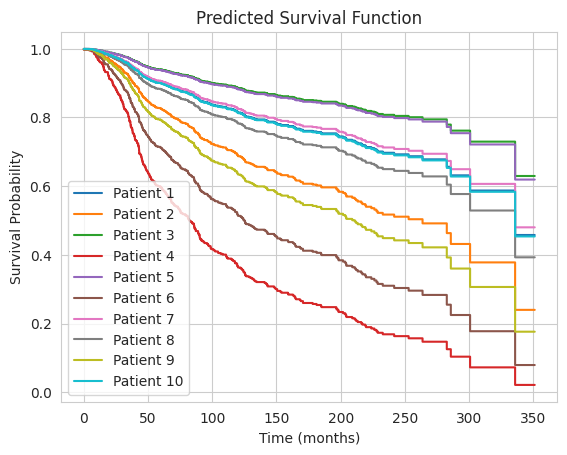

In [64]:
survival_func = cph.predict_survival_function(X_test)

for i in range(10):
    plt.step(survival_func.index, survival_func.iloc[:, i], where="post", label=f"Patient {i+1}")

plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Function")
plt.legend()
plt.show()

### 3 - RSF Model

In [65]:
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [66]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(random_state=42)

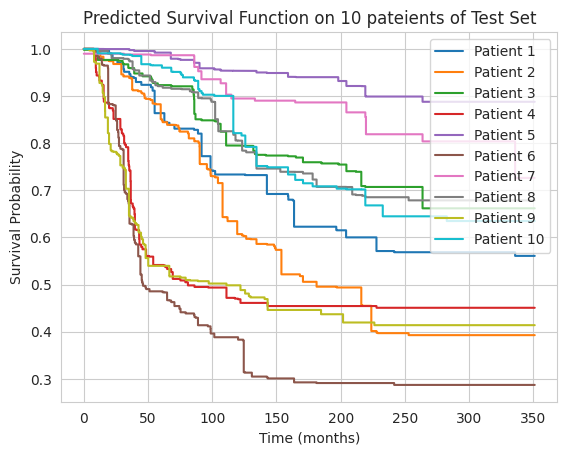

In [67]:
survival_probs = rsf.predict_survival_function(X_test)

for i, survival_func in enumerate(survival_probs[:10]):
    plt.step(survival_func.x, survival_func.y, where="post", label=f"Patient {i+1}")

plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Function on 10 pateients of Test Set")
plt.legend()
plt.show()

### 4 - Performances

In [68]:
times = np.arange(2, 295)

#### A - Brier Score

Brier score on X/y train for COX model

In [69]:
Cox = CoxPHSurvivalAnalysis(ties="efron").fit(X_train, y_train_RSF)
survs = Cox.predict_survival_function(X_test)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_test_RSF, y_test_RSF, preds, times)
print(score)

0.1730712154494318


Brier score on X/y train for RSF model

In [70]:
rsf= RandomSurvivalForest(n_estimators=100, random_state=42).fit(X_train, y_train_RSF)
survs = rsf.predict_survival_function(X_test)
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_test_RSF, y_test_RSF, preds, times)
print(score)

0.16750645860393806


#### B - C-index

In [71]:
y_pred_rsf = rsf.predict(X_test)

In [72]:
c_index = concordance_index_censored(y_test_RSF["Died_of_Desease"], y_test_RSF["overall_survival_months"], y_pred_rsf)[0]
c_index


0.7238546414008156

In [73]:
y_pred_cox = Cox.predict(X_test)

In [74]:
c_index = concordance_index_censored(y_test_RSF["Died_of_Desease"], y_test_RSF["overall_survival_months"], y_pred_cox)[0]
c_index

0.7263132645718398

#### C - Lime

In [75]:
# SurvLime for RSF
#explainer_rsf = SurvLimeExplainer(
#    training_features=X_train,
#    training_events=[tp[0] for tp in y_train_RSF],
#    training_times=[tp[1] for tp in y_train_RSF],
#    model_output_times=rsf.event_times_,
#    random_state=10,
#)

#b_rsf = explainer_rsf.explain_instance(
#    data_row=X_test.iloc[1,:],
#    predict_fn=rsf.predict_cumulative_hazard_function,
#    num_samples=1000,
#    verbose=False,
#)

#explainer_rsf.plot_weights()

#### D - SurvShap

In [76]:
X_exp= X_train.iloc[:20,:5]
y_exp= y.iloc[:20,:]
y_exp = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_exp)


rsf = RandomSurvivalForest(random_state=42, n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=3, max_samples=0.8)
rsf.fit(X_exp, y_exp)
rsf.score(X_exp, y_exp)


0.8618421052631579

In [77]:
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
rsf_exp = SurvivalModelExplainer(rsf, X_exp, y_exp)
cph_exp = SurvivalModelExplainer(cph, X_exp, y_exp)

In [78]:
exp1_survshap_global_rsf = ModelSurvSHAP(random_state=42)
exp1_survshap_global_rsf.fit(rsf_exp)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


In [79]:
import os
os.makedirs("pickles", exist_ok=True)

In [80]:
import itertools
import tqdm

In [81]:
import pickle
with open("pickles/exp1_complex_survshap_global_rsf", "wb") as file:
    pickle.dump(exp1_survshap_global_rsf, file)

In [82]:
import math
from sklearn.metrics import r2_score
def shap_kernel(
    explainer, new_observation, function_type, timestamps, baseline_f, simplified_inputs, kernel_weights, n
):
    data = generate_data(n)

    shap_values, r2 = calculate_shap_values(
        explainer.model,
        function_type,
        baseline_f,
        data,
        simplified_inputs,
        kernel_weights,
        new_observation,
        timestamps,
    )
    result_shap = pd.DataFrame(
        shap_values, columns=[" = ".join(["t", str(time)]) for time in timestamps]
    )

    return result_shap, r2


def generate_shap_kernel_weights(simplified_inputs, num_variables):
    weights = []
    for coalition_vector in simplified_inputs:
        num_available_variables = np.count_nonzero(coalition_vector)
        if num_available_variables == 0 or num_available_variables == num_variables:
            weights.append(1e9)
        else:
            weights.append(
                (num_variables - 1)
                / (
                    math.comb(num_variables, num_available_variables)
                    * num_available_variables
                    * (num_variables - num_available_variables)
                )
            )
    return weights


def make_prediction_for_simplified_input(
    model, function_type, data, simplified_inputs, new_observation, timestamps
):
    preds = np.zeros((len(simplified_inputs), len(timestamps)))
    for i, mask in enumerate(simplified_inputs):
        X_tmp = pd.DataFrame(
            np.where(mask, new_observation, data), columns=data.columns
        )
        preds[
            i,
        ] = calculate_mean_function(model, function_type, X_tmp, timestamps)
    return preds

def calculate_mean_function(model, function_type, data, timestamps):
    if function_type == "sf":
        all_functions = model.predict_survival_function(data)
    elif function_type == "chf":
        all_functions = model.predict_cumulative_hazard_function(data)
    all_function_vals = [f(timestamps) for f in all_functions]
    return np.mean(all_function_vals, axis=0)


def calculate_shap_values(
    model,
    function_type,
    avg_function,
    data,
    simplified_inputs,
    shap_kernel_weights,
    new_observation,
    timestamps,
):
    W = np.diag(shap_kernel_weights)
    X = np.array(simplified_inputs)
    R = np.linalg.inv(X.T @ W @ X) @ (X.T @ W)
    y = (
        make_prediction_for_simplified_input(
            model, function_type, data, simplified_inputs, new_observation, timestamps
        )
        - avg_function
    )
    shap_values = R @ y
    y_pred = X @ shap_values
    r2 = [None] * y.shape[1]
    for i in range(y.shape[1]):
        r2[i] = r2_score(y[:, i], y_pred[:, i], sample_weight=shap_kernel_weights)
    return shap_values, r2

def generate_data(n):
    x1 = np.random.binomial(1, 0.5, n)
    x2 = np.random.binomial(1, 0.5, n)
    x3 = np.random.normal(10, 2, n)
    x4 = np.random.normal(20, 4, n)
    x5 = np.random.normal(0, 1, n)
    return  pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5})

In [83]:
all_functions_rsf = rsf.predict_survival_function(X_exp)
all_functions_vals = [f.y for f in all_functions_rsf]
timestamps = all_functions_rsf[0].x
baseline_f = np.mean(all_functions_vals, axis=0)
simplified_inputs = [list(z) for z in itertools.product(range(2), repeat=5)]
kernel_weights = generate_shap_kernel_weights(simplified_inputs, 5)

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_exp, test_size=0.1, random_state=42, stratify=y_exp["Died_of_Desease"])

In [85]:
shap_groundtruth = pd.DataFrame()
to_calculate = list(X_test.index)
for i in tqdm.tqdm(to_calculate):
    shap_gt = shap_kernel(
        rsf_exp, X_exp.iloc[[i]], "sf", timestamps, baseline_f, simplified_inputs, kernel_weights, 10000
    )
    shap_gt[0].insert(0, "index", i)
    shap_groundtruth = pd.concat([shap_groundtruth, shap_gt[0]])

  0%|          | 0/2 [00:00<?, ?it/s]


IndexError: positional indexers are out-of-bounds

# Graphiques

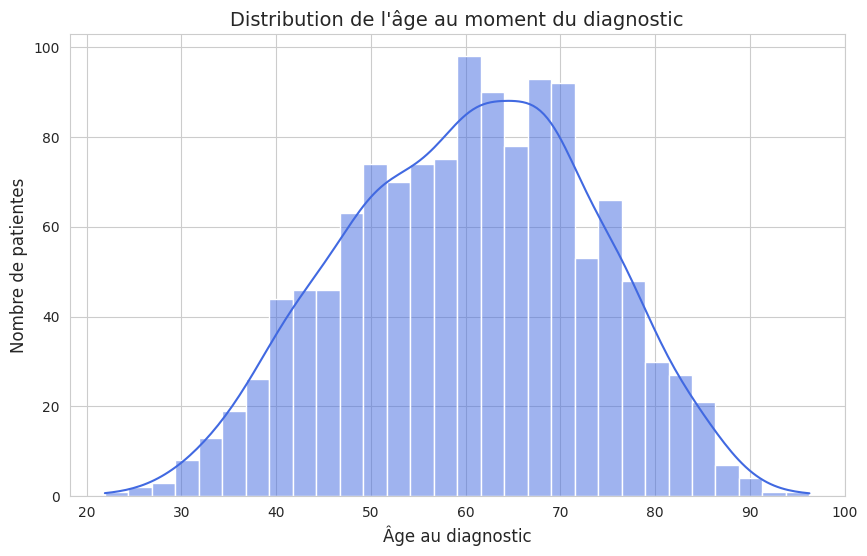

In [86]:
# Définir le style du graphique
sns.set_style("whitegrid")

# Créer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(data["age_at_diagnosis"], bins=30, kde=True, color="royalblue")

# Ajouter des titres et labels
plt.title("Distribution de l'âge au moment du diagnostic", fontsize=14)
plt.xlabel("Âge au diagnostic", fontsize=12)
plt.ylabel("Nombre de patientes", fontsize=12)

# Afficher le graphique
plt.show()

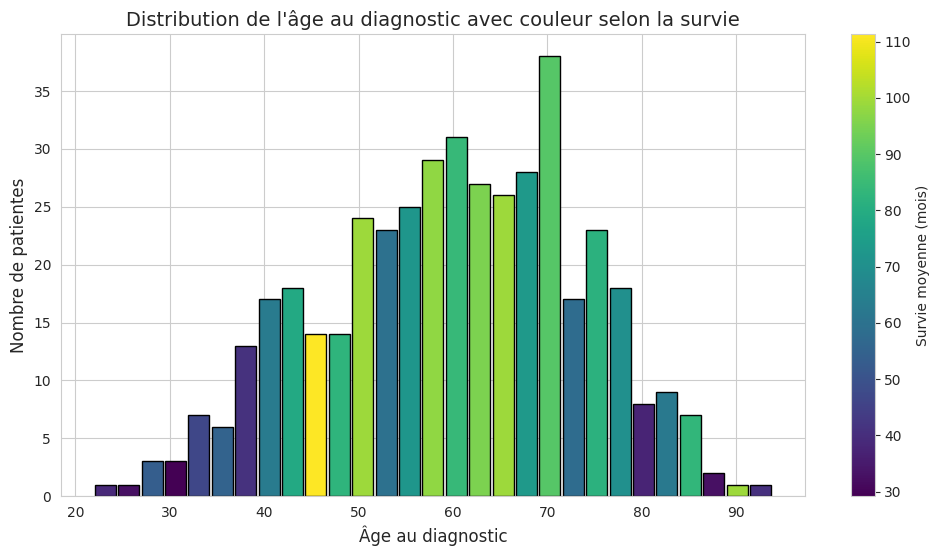

In [87]:
data1=data[data["death_from_cancer"]=="Died of Disease"]

# Définir le style
sns.set_style("whitegrid")

# Définir les bins pour l'histogramme
bins = np.histogram_bin_edges(data1["age_at_diagnosis"], bins=30)

# Assigner chaque patient à un bin
bin_indices = np.digitize(data1["age_at_diagnosis"], bins)  

# Calculer le nombre de patientes et la moyenne des jours de survie pour chaque bin
avg_survival_per_bin = {i: data1.loc[bin_indices == i, "overall_survival_months"].mean() for i in range(1, len(bins))}

# Supprimer les NaN (qui peuvent apparaître si un bin est vide)
avg_survival_per_bin = {k: v for k, v in avg_survival_per_bin.items() if not np.isnan(v)}

# Normaliser les valeurs de survie pour la color map
norm = plt.Normalize(min(avg_survival_per_bin.values()), max(avg_survival_per_bin.values()))
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer l'histogramme avec couleur selon la survie
for i in range(1, len(bins)):
    count = sum(bin_indices == i)
    if count > 0 and i in avg_survival_per_bin:
        ax.bar(
            (bins[i-1] + bins[i]) / 2,  # Position de la barre
            count,  # Hauteur
            width=(bins[i] - bins[i-1]) * 0.9,  # Largeur ajustée
            color=cmap(norm(avg_survival_per_bin[i])),  # Couleur selon la survie
            edgecolor="black"
        )

# Ajouter une barre de couleur avec le bon axe
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Survie moyenne (mois)")

# Ajouter les titres et labels
ax.set_title("Distribution de l'âge au diagnostic avec couleur selon la survie", fontsize=14)
ax.set_xlabel("Âge au diagnostic", fontsize=12)
ax.set_ylabel("Nombre de patientes", fontsize=12)

# Afficher le graphique
plt.show()

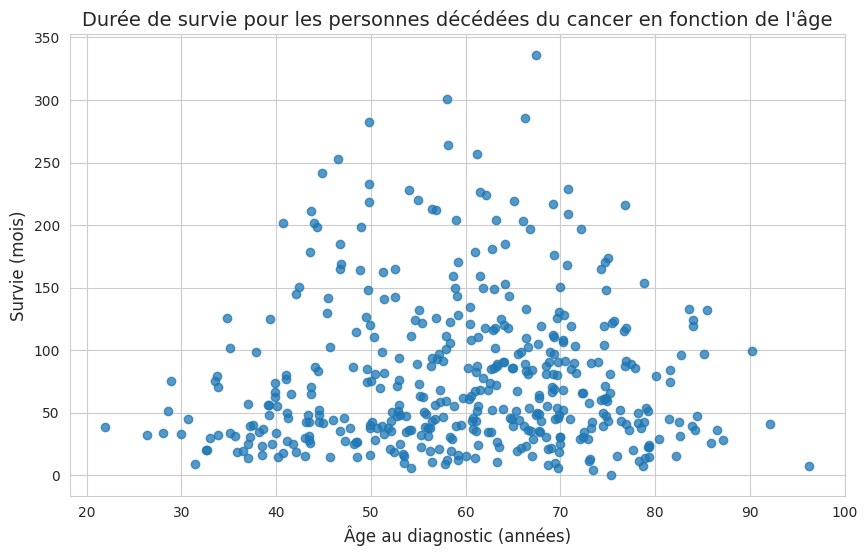

In [88]:
# Définir le style
sns.set_style("whitegrid")

# Créer la figure
plt.figure(figsize=(10, 6))

# Nuage de points
scatter = plt.scatter(
    data1["age_at_diagnosis"], data1["overall_survival_months"],  alpha=0.75
)

# Ajouter une barre de couleur
cbar.set_label("Nombre de mois de survie")

# Ajouter les titres et labels
plt.title("Durée de survie pour les personnes décédées du cancer en fonction de l'âge", fontsize=14)
plt.xlabel("Âge au diagnostic (années)", fontsize=12)
plt.ylabel("Survie (mois)", fontsize=12)

# Afficher le graphique
plt.show()

In [97]:
data1.head(0)

,age_at_diagnosis,type_of_breast_surgery,cancer_type,chemotherapy,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,pr_status,radio_therapy,tumor_size,tumor_stage,death_from_cancer


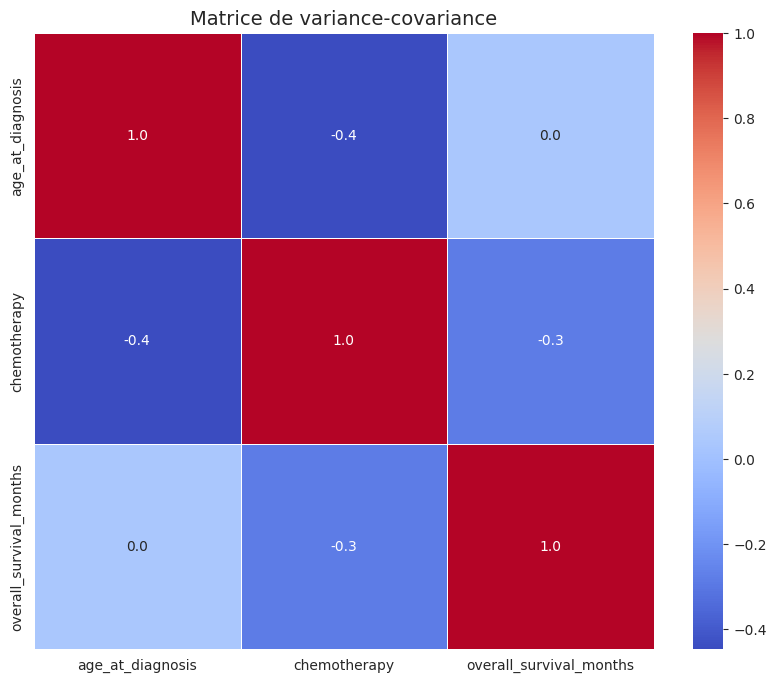

In [102]:
data2 = data1[["age_at_diagnosis", "chemotherapy", "overall_survival_months"]]  # On garde seulement les colonnes numériques

# Calculer la matrice de variance-covariance
cov_matrix = data2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_matrix, 
    annot=True, fmt=".1f", cmap="coolwarm", 
    linewidths=0.5, cbar=True
)

# Ajouter un titre
plt.title("Matrice de variance-covariance", fontsize=14)

# Afficher le graphique
plt.show()

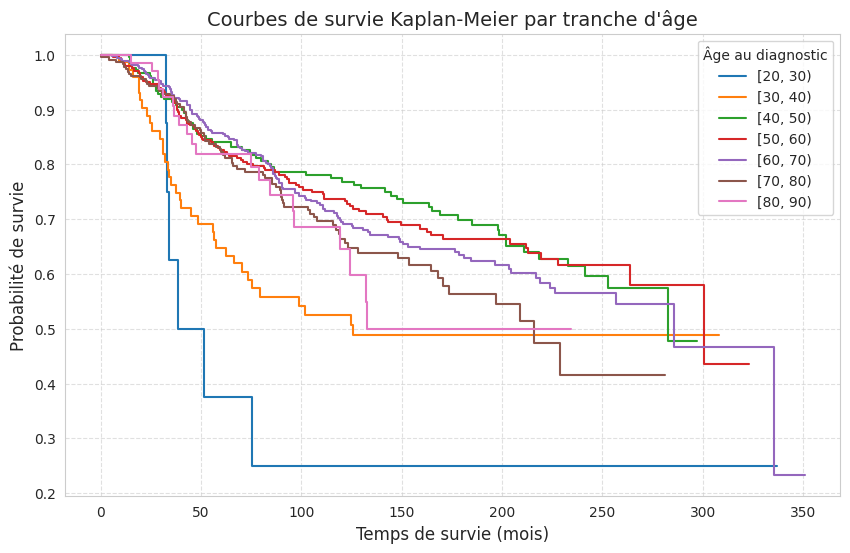

In [120]:
df = pd.get_dummies(data, columns=[
    "cancer_type",
    "type_of_breast_surgery",
    "er_status_measured_by_ihc",
    "er_status",
    "her2_status",
    "inferred_menopausal_state",
    "primary_tumor_laterality",
    "pr_status"],
     drop_first=True)

df['Died_of_Desease'] = (df['death_from_cancer'] == "Died of Disease").astype(int)
df=df.drop("death_from_cancer", axis=1)

# Définir les tranches d'âge (tous les 10 ans)
age_bins = list(range(0, 100, 10)) 
df["age_group"] = pd.cut(df["age_at_diagnosis"], bins=age_bins, right=False)

# Initialiser le graphique
plt.figure(figsize=(10, 6))

# Couleurs pour chaque tranche d'âge
colors = sns.color_palette("tab10", len(age_bins) - 1)

# Tracer les courbes Kaplan-Meier pour chaque tranche d'âge
kmf = KaplanMeierFitter()
for i, (group, color) in enumerate(zip(sorted(df["age_group"].dropna().unique()), colors)):
    mask = df["age_group"] == group
    kmf.fit(df["overall_survival_months"][mask], event_observed=df["Died_of_Desease"][mask], label=f"{group}")
    kmf.plot(ci_show=False, color=color)

# Ajouter titres et légendes
plt.title("Courbes de survie Kaplan-Meier par tranche d'âge", fontsize=14)
plt.xlabel("Temps de survie (mois)", fontsize=12)
plt.ylabel("Probabilité de survie", fontsize=12)
plt.legend(title="Âge au diagnostic")
plt.grid(True, linestyle="--", alpha=0.6)

# Afficher le graphique
plt.show()